# EDA 

Author: hshin337@gatech.edu  
Date: 2/5/2026  




## Findings

1. Use Ploymaket data  
    - Crypto Market interest indicator 
    - Before the year 2020, value set as 0.5

2. Incomplete category need to be reviewed  
    - `bitcoin|btc|crypto|eth|bsv|bch|ada|xrp` for market category classification
    - Before Crypto category count 340
    - After Crypto category count 48,752

3. How to interpret data as an indicator
    - Sentiment score [0, 1]
    - What else?


Data range  
- Crypto market
  - Start date 2020-10-02 20:00:04  
  - End data 2025-12-10 05:32:21 

- Markets_summary
  - Start date 2025-04-07 08:05:19 
  - End data 2026-01-05 05:55:21 

- Markets_odds
  - Start date 2023-01-24 00:00:12 
  - End data 2026-01-05 01:02:10 




In [1]:
import os
from pathlib import Path
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from eda_starter_template import (
    load_bitcoin_data, 
    load_polymarket_data, 
    analyze_btc_metrics, 
    analyze_polymarket_summary, 
    plot_btc_price, 
    plot_polymarket_volume
)

# --- Configuration ---
# Robustly determine the project root directory
SCRIPT_DIR = Path().resolve()
PROJECT_ROOT = SCRIPT_DIR.parent
DATA_DIR = PROJECT_ROOT / "data"
PLOTS_DIR = SCRIPT_DIR / "plots"
COINMETRICS_PATH = DATA_DIR / "Coin Metrics" / "coinmetrics_btc.csv"
POLYMARKET_DIR = DATA_DIR / "Polymarket"

print(f"Project root directory: {PROJECT_ROOT}")

Project root directory: C:\Users\hyuns\workspace\GT-MSA-Spring-2026-Team-09


## Ploymarket
 
markets_path = datadir / "finance_politics_markets.parquet"  
odds_path = datadir / "finance_politics_odds_history.parquet"  
summary_path = datadir / "finance_politics_summary.parquet"  

In [2]:

dict_ploymarket = load_polymarket_data(POLYMARKET_DIR)
df_markets = dict_ploymarket['markets']
df_markets_summary = dict_ploymarket['summary']
df_markets_odds = dict_ploymarket['odds']
df_event_stats = pl.read_parquet(POLYMARKET_DIR / "finance_politics_event_stats.parquet")

def _infer_epoch_unit(series: pl.Series) -> str:
    v = series.drop_nulls().cast(pl.Int64)[0]
    if v < 10 ** 11:
        return "s"
    if v < 10 ** 14:
        return "ms"
    if v < 10 ** 17:
        return "us"
    return "ns"

def fix_epoch_cols(df: pl.DataFrame, cols: list[str]) -> pl.DataFrame:
    unit = _infer_epoch_unit(df.select(cols[0]).to_series())
    return df.with_columns(
        [pl.from_epoch(pl.col(c).cast(pl.Int64), time_unit=unit).alias(c) for c in cols]
    )

df_markets_summary = fix_epoch_cols(df_markets_summary, ["first_trade", "last_trade"])
df_markets_odds = fix_epoch_cols(df_markets_odds, ["timestamp"])

Loading Polymarket data from C:\Users\hyuns\workspace\GT-MSA-Spring-2026-Team-09\data\Polymarket...
[Memory] Before loading Polymarket data: 209.14 MB
Loaded 78321 markets.
Loaded 2143181 odds history records.
Loaded 78321 summary records.
[Memory] After loading Polymarket data: 389.30 MB (Δ 180.16 MB)


In [3]:
print("", df_markets.columns, "\n\n",\
      df_markets_summary.columns, "\n\n", \
        df_markets_odds.columns,"\n\n", \
            df_event_stats.columns)

 ['market_id', 'question', 'slug', 'event_slug', 'category', 'volume', 'active', 'closed', 'created_at', 'end_date'] 

 ['market_id', 'question', 'slug', 'volume', 'active', 'token_count', 'trade_count', 'first_trade', 'last_trade'] 

 ['market_id', 'token_id', 'timestamp', 'price'] 

 ['event_slug', 'market_count', 'total_volume', 'first_market_start', 'last_market_end']


In [4]:
# Count Crypto category before
print('Before Crypto category count', df_markets.filter(pl.col('category') == 'Crypto').height)

# queen-elizabeth-ii-jubilee-stakes-winner
# Update category using Polars conditional logic
df_markets = df_markets.with_columns(
    pl.when(
        (pl.col('category').str.strip_chars() == '') &
        (pl.col('question').str.to_lowercase().str.contains(r'\b(bitcoin|btc|crypto|eth|bsv|bch|ada|xrp)\b'))
    ).then(pl.lit('Crypto'))
    .otherwise(pl.col('category'))
    .alias('category')
)

# Count Crypto category after
print('After Crypto category count', df_markets.filter(pl.col('category') == 'Crypto').height)

Before Crypto category count 340
After Crypto category count 27662


Crypto Market volume

<Axes: title={'center': 'Number of Markets by Category'}, ylabel='category'>

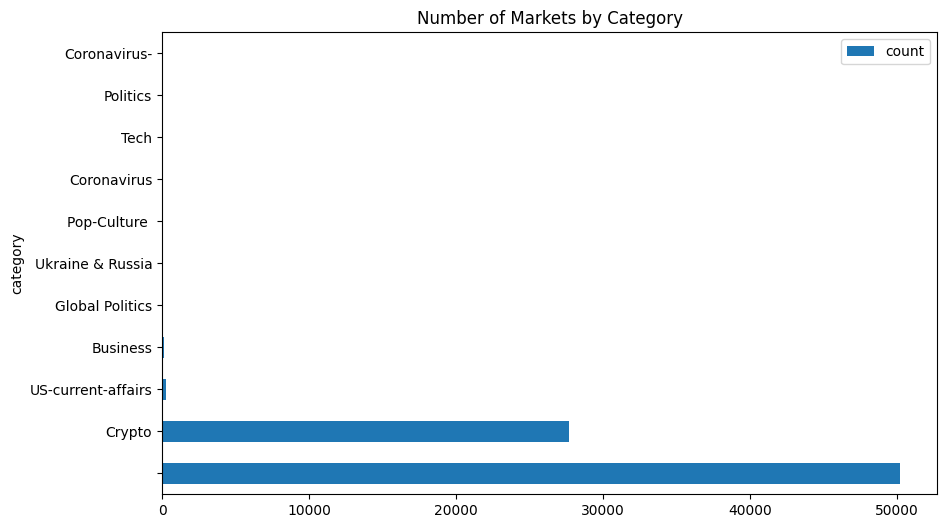

In [5]:
df_markets.group_by('category').agg(pl.len().alias('count')).sort('count', descending=True).\
    to_pandas().plot(x='category', y='count', kind='barh', title='Number of Markets by Category', figsize=(10, 6))

array([[<Axes: title={'center': 'created_at'}>]], dtype=object)

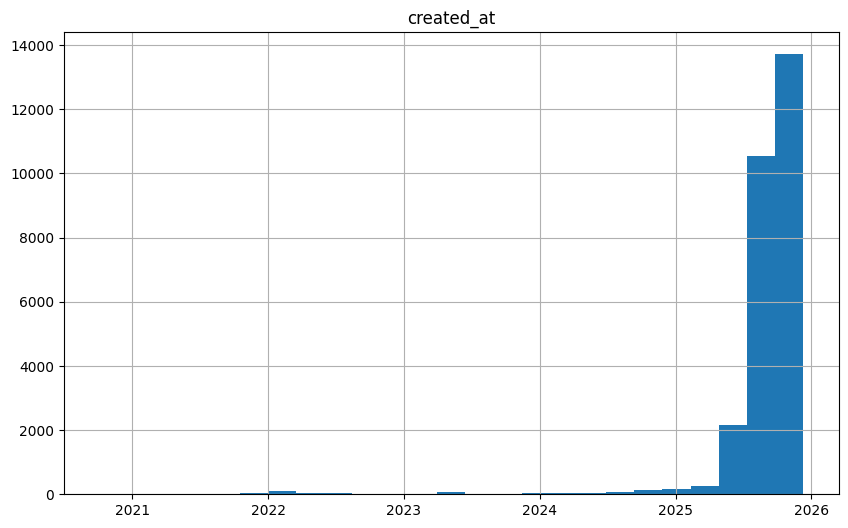

In [6]:
crypto_markets = df_markets.filter(pl.col('category') == 'Crypto').sort('created_at', descending=False)  
crypto_markets.to_pandas().hist(column='created_at', bins=25, figsize=(10, 6))

Date ranges


In [7]:
print('Crypot market\nStart date', crypto_markets['created_at'].min(), '\nEnd data', crypto_markets['created_at'].max(), '\n')

print('df_markets_summary\nStart date', df_markets_summary['first_trade'].min(), '\nEnd data', df_markets_summary['first_trade'].max(), '\n')

print('df_markets_odds\nStart date', df_markets_odds['timestamp'].min(), '\nEnd data', df_markets_odds['timestamp'].max(), '\n')

Crypot market
Start date 2020-10-02 20:00:04 
End data 2025-12-10 05:32:19 

df_markets_summary
Start date 2025-04-07 08:05:19 
End data 2026-01-05 05:55:21 

df_markets_odds
Start date 2023-01-24 00:00:12 
End data 2026-01-05 01:02:10 



Market question samples

In [8]:
# Randomly sample 10 questions from crypto markets
sampled_questions = crypto_markets.select(['question', 'created_at', 'category']).sample(n=20)
print("Random 20 Crypto Market Questions:")
print("=" * 80)
for idx, row in enumerate(sampled_questions.to_pandas().itertuples(), 1):
    print(f"{idx:02d}. [{row.created_at.strftime('%Y-%m-%d')}] {row.question} ({row.category})")

Random 20 Crypto Market Questions:
01. [2025-09-26] Will the price of XRP be above $2.70 on September 26 at 4PM ET? (Crypto)
02. [2025-06-11] Will the price of Bitcoin be less than $108K on June 12 at 5 PM ET? (Crypto)
03. [2025-10-11] Bitcoin Up or Down - October 11, 10:45PM-11:00PM ET (Crypto)
04. [2025-11-10] MicroStrategy announces >1000 BTC purchase November 11-17? (Crypto)
05. [2025-11-29] Bitcoin Up or Down - November 30, 8:00AM-8:15AM ET (Crypto)
06. [2025-05-09] Will Bitcoin close above $104K on May 16? (Crypto)
07. [2025-11-03] Bitcoin Up or Down - November 3, 7:00AM-7:15AM ET (Crypto)
08. [2025-08-23] Bitcoin above $115K on August 24 at 4PM ET? (Crypto)
09. [2025-11-16] Bitcoin Up or Down - November 17, 3:30AM-3:45AM ET (Crypto)
10. [2025-05-02] Will the price of Bitcoin be greater than $103000 on May 9? (Crypto)
11. [2025-08-20] Bitcoin above $114K on August 27? (Crypto)
12. [2025-10-28] Bitcoin Up or Down - October 28, 6:45AM-7:00AM ET (Crypto)
13. [2025-10-14] Bitcoin Up 

In [9]:
crypto_markets.group_by(pl.col('event_slug')).agg(pl.len().alias('count')).sort('count', descending=True)

event_slug,count
str,u32
"""what-price-will-bitcoin-hit-in…",28
"""what-will-trump-say-during-cry…",22
"""what-price-will-bitcoin-hit-in…",21
"""what-price-will-bitcoin-hit-in…",20
"""what-price-will-bitcoin-hit-in…",19
…,…
"""btc-up-or-down-15m-1758927600""",1
"""btc-updown-15m-1763082900""",1
"""btc-updown-15m-1763269200""",1


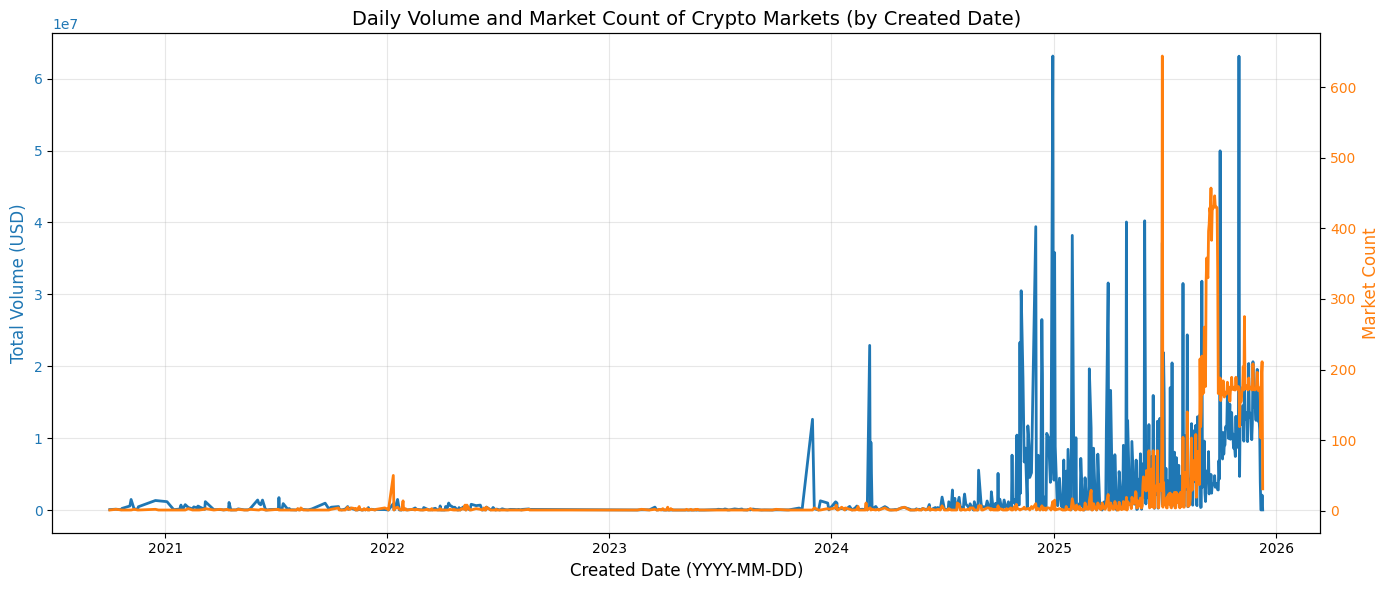

In [10]:
# Group crypto markets by created_at date and sum volume
crypto_daily_volume = (
    crypto_markets
    .with_columns(pl.col('created_at').cast(pl.Date).alias('date'))
    .group_by('date')
    .agg(pl.col('volume').sum().alias('daily_volume'), pl.col('market_id').count().alias('daily_market_count'))
    .sort('date')
)

# Plot with dual y-axis
plt.figure(figsize=(14, 6))
pd_crypto_daily_volume = crypto_daily_volume.to_pandas()

ax1 = plt.gca()
ax1.plot(pd_crypto_daily_volume['date'], pd_crypto_daily_volume['daily_volume'], color='tab:blue', linewidth=2, label='Daily Volume')
ax1.set_xlabel('Created Date (YYYY-MM-DD)', fontsize=12)
ax1.set_ylabel('Total Volume (USD)', fontsize=12, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(pd_crypto_daily_volume['date'], pd_crypto_daily_volume['daily_market_count'], 
         color='tab:orange', linewidth=2, label='Daily Market Count')
ax2.set_ylabel('Market Count', fontsize=12, color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Daily Volume and Market Count of Crypto Markets (by Created Date)', fontsize=14)
ax1.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

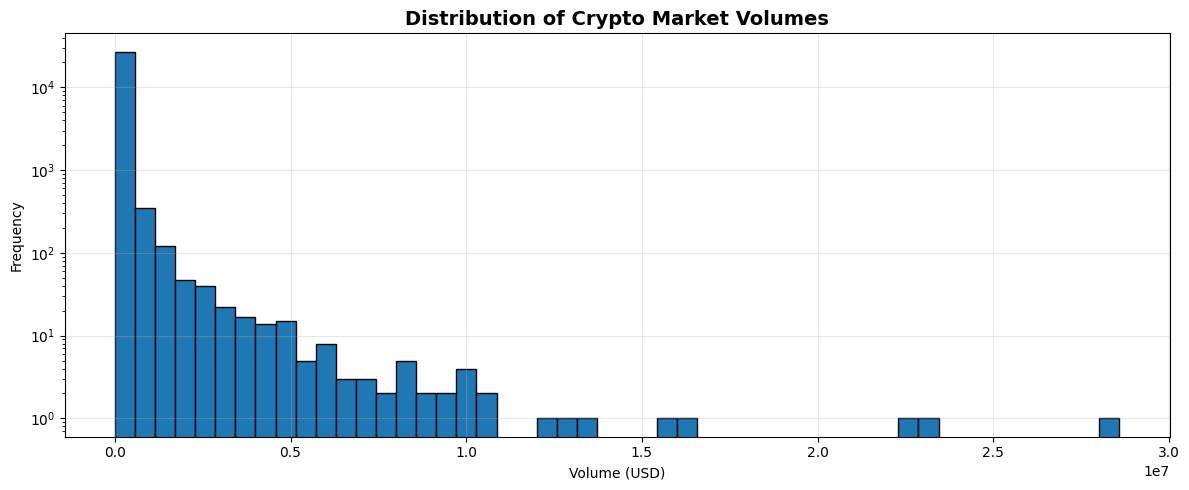

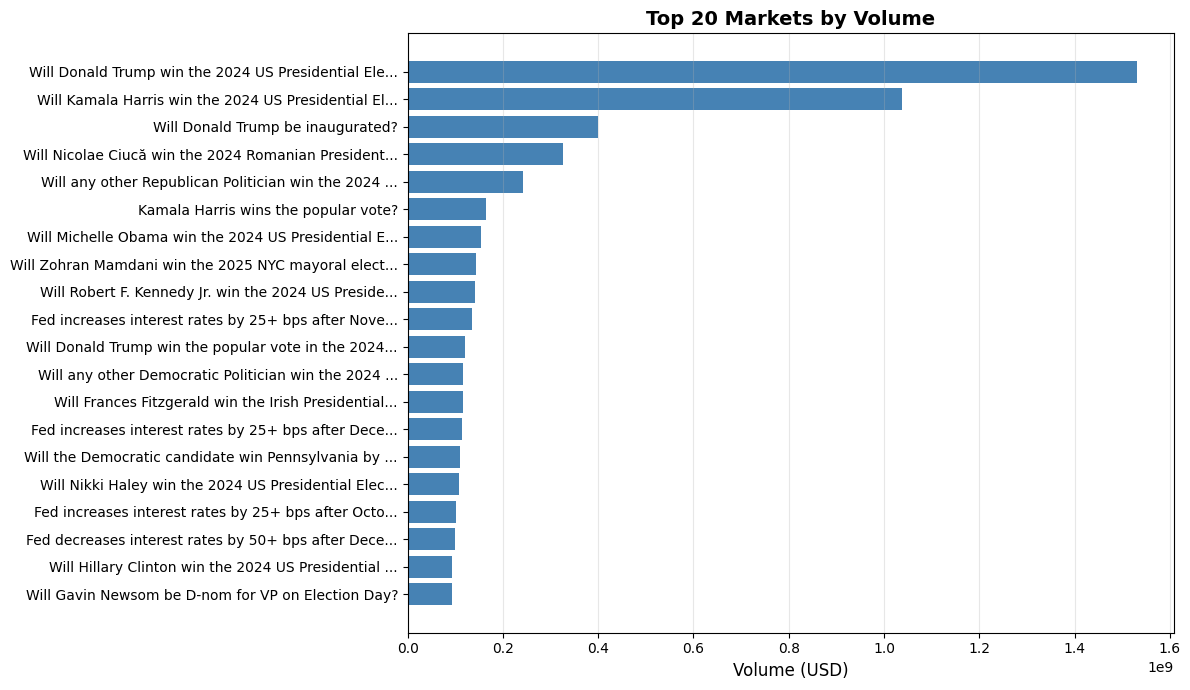

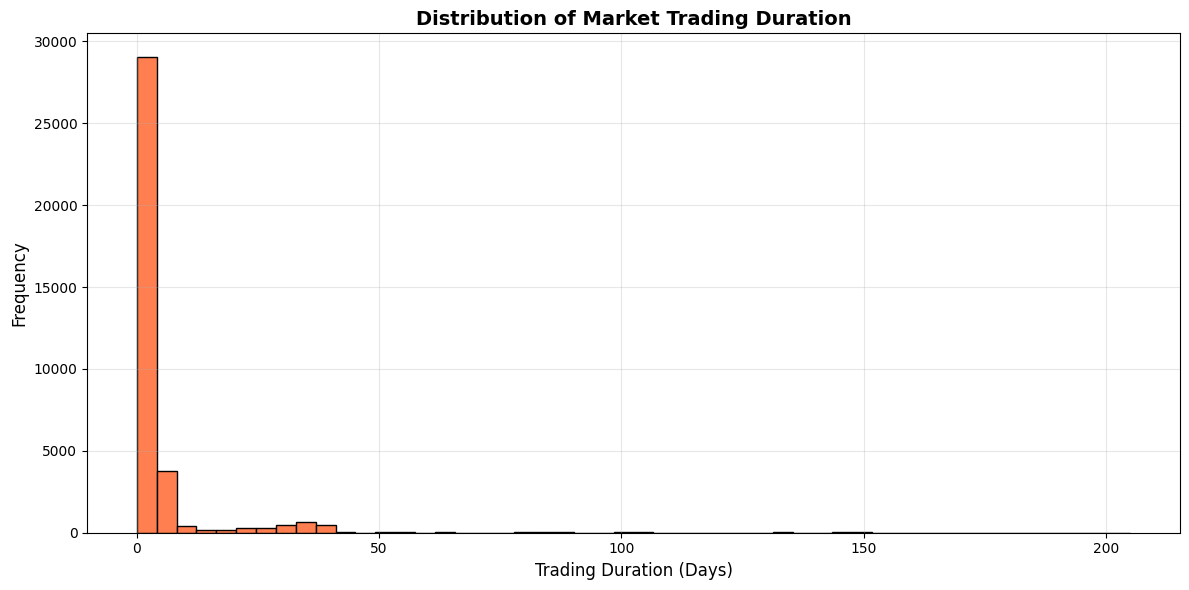

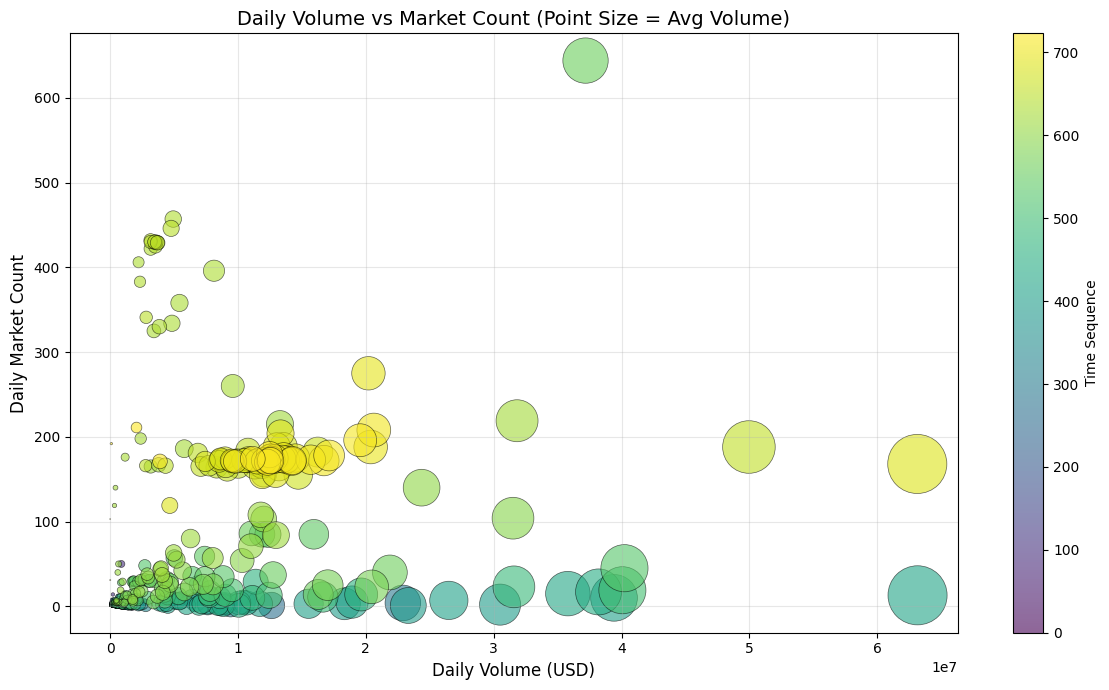

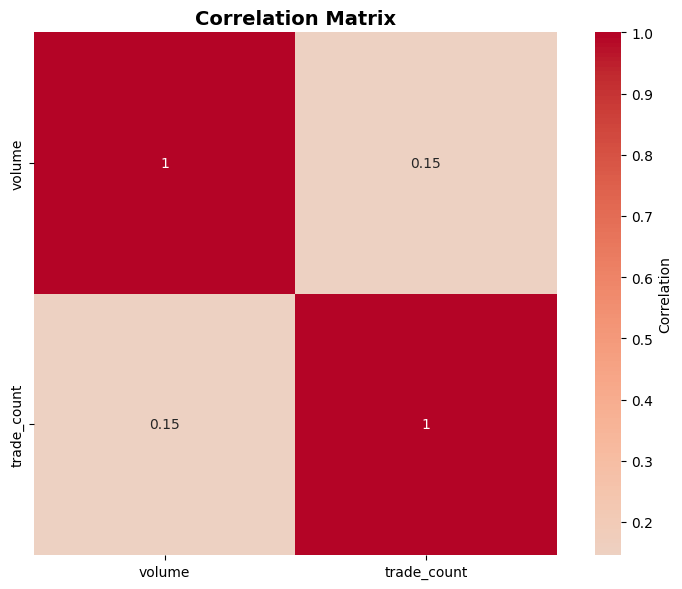

In [22]:
import numpy as np

# Crypto Market Volume Distribution
plt.figure(figsize=(12, 5))
crypto_markets.to_pandas()['volume'].hist(bins=50, edgecolor='black')
plt.title('Distribution of Crypto Market Volumes', fontsize=14, fontweight='bold')
plt.xlabel('Volume (USD)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

df_summary_pd = df_markets_summary.to_pandas()

# Top 20 High Volume Markets
plt.figure(figsize=(12, 7))
top_markets = df_summary_pd.nlargest(20, 'volume')[['question', 'volume']].sort_values('volume', ascending=True)
plt.barh(range(len(top_markets)), top_markets['volume'].values, color='steelblue')
plt.yticks(range(len(top_markets)), 
          [q[:50] + '...' if len(q) > 50 else q for q in top_markets['question'].values])
plt.xlabel('Volume (USD)', fontsize=12)
plt.title('Top 20 Markets by Volume', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Duration
plt.figure(figsize=(12, 6))
df_summary_pd['duration_days'] = (df_summary_pd['last_trade'] - df_summary_pd['first_trade']).dt.days
plt.hist(df_summary_pd['duration_days'], bins=50, edgecolor='black', color='coral')
plt.xlabel('Trading Duration (Days)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Market Trading Duration', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Scatter plot: Volume vs Market Count with average volume as size
plt.figure(figsize=(12, 7))

# Calculate average volume per point for sizing
avg_volume_for_size = pd_crypto_daily_volume['daily_volume'].mean()
sizes = (pd_crypto_daily_volume['daily_volume'] / avg_volume_for_size) * 100  # Scale for visibility

plt.scatter(pd_crypto_daily_volume['daily_volume'], pd_crypto_daily_volume['daily_market_count'], 
           s=sizes, alpha=0.6, c=pd_crypto_daily_volume.index, cmap='viridis', edgecolors='black', linewidth=0.5)

plt.xlabel('Daily Volume (USD)', fontsize=12)
plt.ylabel('Daily Market Count', fontsize=12)
plt.title('Daily Volume vs Market Count (Point Size = Avg Volume)', fontsize=14)
plt.colorbar(label='Time Sequence')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Volume, Trade Count, Token Count Corr.
import seaborn as sns
plt.figure(figsize=(8, 6))
corr_data = df_summary_pd[['volume', 'trade_count']].corr()
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, square=True, 
           cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Create join dataframe between crypto_markets and summary by slug(str)

Details  
Sampling market_id = 798778

In [23]:
crypto_markets = crypto_markets.with_columns(
    (pl.col('end_date') - pl.col('created_at'))
    .dt.total_minutes()
    .floor()
    .alias('market_open_duration_minutes')
)
crypto_markets.filter(pl.col('market_id') == "798778")

market_id,question,slug,event_slug,category,volume,active,closed,created_at,end_date,market_open_duration_minutes
str,str,str,str,str,f64,bool,bool,datetime[μs],datetime[μs],i64
"""798778""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…","""bitcoin-price-on-december-9""","""Crypto""",8756.369075,true,false,2025-12-02 17:00:02,2025-12-09 17:00:00,10079


In [24]:
df_markets_summary = df_markets_summary.with_columns(
    (pl.col("last_trade") - pl.col("first_trade"))
    .dt.total_minutes()
    .floor()
    .alias("actual_market_trade_duration_minutes")
)

df_markets_summary.filter(pl.col('market_id')=='798778')


market_id,question,slug,volume,active,token_count,trade_count,first_trade,last_trade,actual_market_trade_duration_minutes
str,str,str,f64,bool,i64,i64,datetime[ms],datetime[ms],i64
"""798778""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",8756.369075,true,2,279,2025-12-09 04:35:47,2025-12-09 12:51:41,495


In [25]:
print(f'{crypto_markets.head(1)}\n{df_markets_summary.head(1)}')

shape: (1, 11)
┌───────────┬────────────┬────────────┬───────────┬───┬────────┬───────────┬───────────┬───────────┐
│ market_id ┆ question   ┆ slug       ┆ event_slu ┆ … ┆ closed ┆ created_a ┆ end_date  ┆ market_op │
│ ---       ┆ ---        ┆ ---        ┆ g         ┆   ┆ ---    ┆ t         ┆ ---       ┆ en_durati │
│ str       ┆ str        ┆ str        ┆ ---       ┆   ┆ bool   ┆ ---       ┆ datetime[ ┆ on_minute │
│           ┆            ┆            ┆ str       ┆   ┆        ┆ datetime[ ┆ μs]       ┆ s         │
│           ┆            ┆            ┆           ┆   ┆        ┆ μs]       ┆           ┆ ---       │
│           ┆            ┆            ┆           ┆   ┆        ┆           ┆           ┆ i64       │
╞═══════════╪════════════╪════════════╪═══════════╪═══╪════════╪═══════════╪═══════════╪═══════════╡
│ 36        ┆ What will  ┆ what-will- ┆ what-will ┆ … ┆ true   ┆ 2020-10-0 ┆ 2020-11-0 ┆ 46319     │
│           ┆ the price  ┆ the-price- ┆ -the-pric ┆   ┆        ┆ 2         ┆

In [26]:
# df_markets_summary.filter(pl.col('market_id') == "798778")
crypto_markets.filter(pl.col('market_id') == "798778")[0]['slug'][0]

'will-the-price-of-bitcoin-be-between-88000-90000-on-december-9'

Sampling slug = "will-binancecom-become-insolvent-by-feb-28-2023"  

In [27]:
# _slug = "will-binancecom-become-insolvent-by-feb-28-2023"
_slug = "will-the-price-of-bitcoin-be-between-88000-90000-on-december-9"
df_markets_summary.filter(pl.col('slug') == _slug)

market_id,question,slug,volume,active,token_count,trade_count,first_trade,last_trade,actual_market_trade_duration_minutes
str,str,str,f64,bool,i64,i64,datetime[ms],datetime[ms],i64
"""798778""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",8756.369075,true,2,279,2025-12-09 04:35:47,2025-12-09 12:51:41,495


In [28]:
joined_crypto_summary = (
    crypto_markets
    .join(
        df_markets_summary,
        on="market_id",
        how="inner",
        suffix="_summary",
    )
    .select(
        [
            "market_id",
            "question",
            "slug",
            "volume",
            "trade_count",
            "created_at",
            "end_date",
            "market_open_duration_minutes",
            "first_trade",
            "last_trade",
            "actual_market_trade_duration_minutes",
        ]
    )
    .with_columns(
        pl.when(
            (pl.col("market_open_duration_minutes").is_null()) |
            (pl.col("market_open_duration_minutes") <= 0)
        )
        .then(pl.lit(None))
        .otherwise(
            (pl.col("actual_market_trade_duration_minutes") /
             pl.col("market_open_duration_minutes"))
            .clip(0.0, 1.0)
        )
        .alias("active_trade_ratio")\
            #.fill_null(0)
    )
)

joined_crypto_summary.head()

market_id,question,slug,volume,trade_count,created_at,end_date,market_open_duration_minutes,first_trade,last_trade,actual_market_trade_duration_minutes,active_trade_ratio
str,str,str,f64,i64,datetime[μs],datetime[μs],i64,datetime[ms],datetime[ms],i64,f64
"""798778""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",8756.369075,279,2025-12-02 17:00:02,2025-12-09 17:00:00,10079,2025-12-09 04:35:47,2025-12-09 12:51:41,495,0.049112
"""687200""","""Will Bitcoin reach $100,000 by…","""will-bitcoin-reach-100000-by-d…",3.0088e6,6795,2025-11-17 16:10:33,2026-01-01 05:00:00,64129,2025-11-26 11:11:15,2026-01-01 05:26:25,51495,0.802991
"""865705""","""Will the price of XRP be betwe…","""will-the-price-of-xrp-be-betwe…",0.0,4,2025-12-06 17:00:07,2025-12-13 17:00:00,10079,2025-12-08 12:30:31,2025-12-08 15:22:51,172,0.017065
"""894893""","""Bitcoin Up or Down - December …","""btc-updown-15m-1765282500""",3.920783,1178,2025-12-08 12:17:21,2025-12-09 12:30:00,1452,2025-12-08 12:37:29,2025-12-09 12:30:23,1432,0.986226
"""834874""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",21.978011,1,2025-12-05 17:00:02,2025-12-12 17:00:00,10079,2025-12-07 17:12:25,2025-12-07 17:12:25,0,0.0


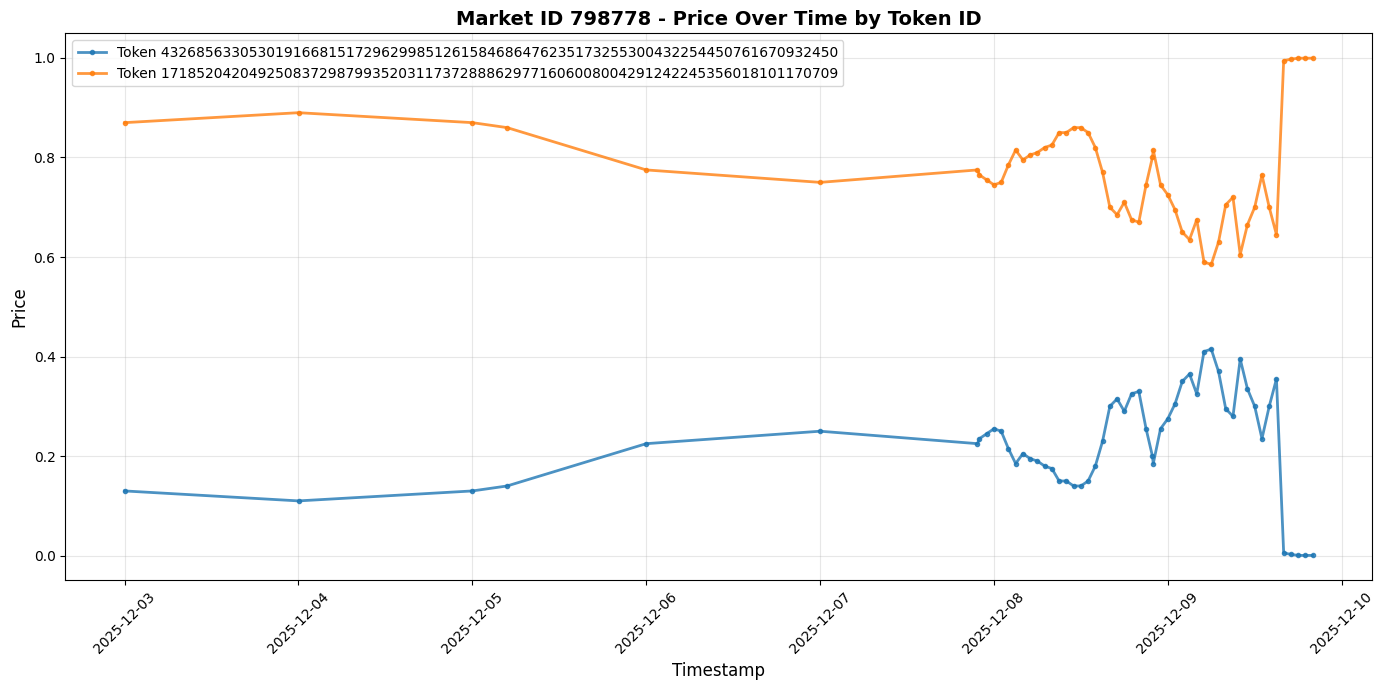


Price Statistics by Token ID:
                                                       price                  \
                                                        mean     min     max   
token_id                                                                       
17185204204925083729879935203117372888629771606...  0.773555  0.5850  0.9995   
43268563305301916681517296299851261584686476235...  0.226445  0.0005  0.4150   

                                                                    
                                                         std count  
token_id                                                            
17185204204925083729879935203117372888629771606...  0.105207    55  
43268563305301916681517296299851261584686476235...  0.105207    55  


In [29]:
import polars as pl
import matplotlib.pyplot as plt

target_market_id = "798778"
market_798778 = (
    df_markets_odds
    .filter(pl.col("market_id") == target_market_id)
    .sort("timestamp")
)
# market_798778
# print(market_798778.columns)
# print(market_798778.to_pandas().groupby('token_id').agg({'price': 'mean'}).columns)
#    .sort_values(by='timestamp').plot(x='timestamp', y='price', title='Market ID 798778 - Yes Price Over Time')

# Convert to pandas for plotting
market_798778_pd = market_798778.to_pandas()

# Plot price over time by token_id
plt.figure(figsize=(14, 7))
for token_id in market_798778_pd['token_id'].unique():
    token_data = market_798778_pd[market_798778_pd['token_id'] == token_id]
    plt.plot(token_data['timestamp'], token_data['price'], 
             marker='o', markersize=3, linewidth=2, label=f'Token {token_id}', alpha=0.8)

plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Market ID 798778 - Price Over Time by Token ID', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: Show summary statistics
print("\nPrice Statistics by Token ID:")
print(market_798778_pd.groupby('token_id').agg({
    'price': ['mean', 'min', 'max', 'std', 'count']
}))

In [37]:
df_market_odds_std = df_markets_odds.group_by('market_id').agg(pl.std('price').alias('std_token_price'))
df_market_odds_std

market_id,std_token_price
str,f64
"""250122""",0.016296
"""605534""",0.439059
"""681747""",0.004082
"""683976""",0.0
"""553008""",0.0
…,…
"""631058""",0.133608
"""637356""",0.0
"""811721""",0.474663


In [91]:
joined_crypto_summary_std_token_price = joined_crypto_summary.join(
    df_market_odds_std,
    on="market_id",
    how="left",
).with_columns(
    pl.col("std_token_price").fill_null(0)
)
joined_crypto_summary_std_token_price

market_id,question,slug,volume,trade_count,created_at,end_date,market_open_duration_minutes,first_trade,last_trade,actual_market_trade_duration_minutes,active_trade_ratio,std_token_price
str,str,str,f64,i64,datetime[μs],datetime[μs],i64,datetime[ms],datetime[ms],i64,f64,f64
"""798778""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",8756.369075,279,2025-12-02 17:00:02,2025-12-09 17:00:00,10079,2025-12-09 04:35:47,2025-12-09 12:51:41,495,0.049112,0.294084
"""687200""","""Will Bitcoin reach $100,000 by…","""will-bitcoin-reach-100000-by-d…",3.0088e6,6795,2025-11-17 16:10:33,2026-01-01 05:00:00,64129,2025-11-26 11:11:15,2026-01-01 05:26:25,51495,0.802991,0.296799
"""865705""","""Will the price of XRP be betwe…","""will-the-price-of-xrp-be-betwe…",0.0,4,2025-12-06 17:00:07,2025-12-13 17:00:00,10079,2025-12-08 12:30:31,2025-12-08 15:22:51,172,0.017065,0.472366
"""894893""","""Bitcoin Up or Down - December …","""btc-updown-15m-1765282500""",3.920783,1178,2025-12-08 12:17:21,2025-12-09 12:30:00,1452,2025-12-08 12:37:29,2025-12-09 12:30:23,1432,0.986226,0.00101
"""834874""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",21.978011,1,2025-12-05 17:00:02,2025-12-12 17:00:00,10079,2025-12-07 17:12:25,2025-12-07 17:12:25,0,0.0,0.419105
…,…,…,…,…,…,…,…,…,…,…,…,…
"""697320""","""Will the price of XRP be betwe…","""will-the-price-of-xrp-be-betwe…",15985.352289,0,2025-11-22 17:00:11,2025-11-29 17:00:00,10079,null,null,null,null,0.322499
"""240547""","""Will Dharma airdrop a native t…","""will-dharma-airdrop-a-native-t…",10028.65,0,2022-01-11 18:52:51,2022-03-31 00:00:00,112627,null,null,null,null,0.0
"""224954""","""Will it be possible to buy a T…","""will-it-be-possible-to-buy-a-t…",45525.31,0,2021-07-22 19:20:01,2022-01-01 00:00:00,233559,null,null,null,null,0.0


In [ ]:
joined_crypto_summary_std_token_price.describe()

statistic,market_id,question,slug,volume,trade_count,created_at,end_date,market_open_duration_minutes,first_trade,last_trade,actual_market_trade_duration_minutes,active_trade_ratio,std_price
str,str,str,str,f64,f64,str,str,f64,str,str,f64,f64,f64
"""count""","""27662""","""27662""","""27662""",27662.0,27662.0,"""27662""","""27601""",27601.0,"""12854""","""12854""",12854.0,12789.0,27662.0
"""null_count""","""0""","""0""","""0""",0.0,0.0,"""0""","""61""",61.0,"""14808""","""14808""",14808.0,14873.0,0.0
"""mean""",null,null,null,91188.350303,474.192394,"""2025-08-30 23:30:01.184404""","""2025-09-04 23:25:56.376218""",7097.482627,"""2025-09-29 18:54:32.033000""","""2025-10-01 12:24:46.044000""",2489.777112,0.427497,0.134345
"""std""",null,null,null,501848.802261,1253.857032,null,null,34213.559589,null,null,6596.570661,0.339889,0.211858
"""min""","""101490""","""$BITCOIN (HPOS10i) all time hi…","""ageagea-958-915""",0.0,0.0,"""2020-10-02 20:00:04""","""2020-01-01 00:00:00""",-454695.0,"""2025-04-07 08:05:21""","""2025-04-07 08:42:59""",0.0,0.0,0.0
"""25%""",null,null,null,599.566231,0.0,"""2025-09-08 02:00:01""","""2025-09-09 08:00:00""",359.0,"""2025-09-09 15:51:32""","""2025-09-10 12:31:09""",76.0,0.130165,0.0
"""50%""",null,null,null,15081.99658,0.0,"""2025-09-25 05:16:56""","""2025-09-26 12:00:00""",1452.0,"""2025-10-02 07:43:51""","""2025-10-03 23:01:27""",289.0,0.329114,0.0
"""75%""",null,null,null,66855.554621,256.0,"""2025-10-31 16:01:47""","""2025-11-03 15:15:00""",5750.0,"""2025-11-04 04:05:05""","""2025-11-05 12:29:25""",1808.0,0.765456,0.313382
"""max""","""98685""","""[From kain.eth] Will Synthetix…","""xrp-multistrike-4h-1759003200-…",2.8587e7,43097.0,"""2025-12-10 05:32:19""","""2027-01-01 05:00:00""",739550.0,"""2025-12-16 20:02:03""","""2026-01-05 06:31:01""",130962.0,1.0,0.7064


In [ ]:
joined_crypto_summary_std_token_price_filtered = joined_crypto_summary_std_token_price.filter(
    pl.col('created_at').is_not_null(), pl.col('first_trade').is_not_null()
    )
joined_crypto_summary_std_token_price_filtered

market_id,question,slug,volume,trade_count,created_at,end_date,market_open_duration_minutes,first_trade,last_trade,actual_market_trade_duration_minutes,active_trade_ratio,std_price
str,str,str,f64,i64,datetime[μs],datetime[μs],i64,datetime[ms],datetime[ms],i64,f64,f64
"""798778""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",8756.369075,279,2025-12-02 17:00:02,2025-12-09 17:00:00,10079,2025-12-09 04:35:47,2025-12-09 12:51:41,495,0.049112,0.294084
"""687200""","""Will Bitcoin reach $100,000 by…","""will-bitcoin-reach-100000-by-d…",3.0088e6,6795,2025-11-17 16:10:33,2026-01-01 05:00:00,64129,2025-11-26 11:11:15,2026-01-01 05:26:25,51495,0.802991,0.296799
"""865705""","""Will the price of XRP be betwe…","""will-the-price-of-xrp-be-betwe…",0.0,4,2025-12-06 17:00:07,2025-12-13 17:00:00,10079,2025-12-08 12:30:31,2025-12-08 15:22:51,172,0.017065,0.472366
"""894893""","""Bitcoin Up or Down - December …","""btc-updown-15m-1765282500""",3.920783,1178,2025-12-08 12:17:21,2025-12-09 12:30:00,1452,2025-12-08 12:37:29,2025-12-09 12:30:23,1432,0.986226,0.00101
"""834874""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",21.978011,1,2025-12-05 17:00:02,2025-12-12 17:00:00,10079,2025-12-07 17:12:25,2025-12-07 17:12:25,0,0.0,0.419105
…,…,…,…,…,…,…,…,…,…,…,…,…
"""594352""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",3612.0,2,2025-09-11 22:00:01,2025-09-12 04:00:00,359,2025-09-12 03:51:13,2025-09-12 03:51:13,0,0.0,0.0
"""557086""","""Bitcoin Up or Down - July 17, …","""bitcoin-up-or-down-july-17-2pm…",36028.12231,743,2025-06-28 20:42:25,2025-07-17 19:00:00,27257,2025-07-16 20:04:32,2025-07-17 19:50:40,1426,0.052317,0.0
"""572176""","""Will Trump say ""Crypto"" or ""Bi…","""will-trump-say-crypto-or-bitco…",42908.041491,170,2025-08-04 23:57:55,2025-08-05 00:00:00,2,2025-08-05 01:29:05,2025-08-05 14:36:21,787,1.0,0.0


In [ ]:
# joined_crypto_summary_std_token_price.to_pandas().plot(x='created_at', y='trade_count', kind='scatter', title='Standard Deviation of Price vs Created Date', figsize=(10, 6))

joined_crypto_summary_std_token_price = joined_crypto_summary_std_token_price.with_columns(
    (
        (pl.col("trade_count") - pl.col("trade_count").min())
        / (pl.col("trade_count").max() - pl.col("trade_count").min())
    ).alias("trade_count_norm")
)

# joined_crypto_summary_std_token_price = joined_crypto_summary_std_token_price.with_columns(
#     pl.log1p("trade_count").alias("trade_count_log")
# ).with_columns(
#     (
#         (pl.col("trade_count_log") - pl.col("trade_count_log").min())
#         / (pl.col("trade_count_log").max() - pl.col("trade_count_log").min())
#     ).alias("trade_count_log_norm")
# )

joined_crypto_summary_std_token_price

market_id,question,slug,volume,trade_count,created_at,end_date,market_open_duration_minutes,first_trade,last_trade,actual_market_trade_duration_minutes,active_trade_ratio,std_token_price,trade_count_norm
str,str,str,f64,i64,datetime[μs],datetime[μs],i64,datetime[ms],datetime[ms],i64,f64,f64,f64
"""798778""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",8756.369075,279,2025-12-02 17:00:02,2025-12-09 17:00:00,10079,2025-12-09 04:35:47,2025-12-09 12:51:41,495,0.049112,0.294084,0.006474
"""687200""","""Will Bitcoin reach $100,000 by…","""will-bitcoin-reach-100000-by-d…",3.0088e6,6795,2025-11-17 16:10:33,2026-01-01 05:00:00,64129,2025-11-26 11:11:15,2026-01-01 05:26:25,51495,0.802991,0.296799,0.157668
"""865705""","""Will the price of XRP be betwe…","""will-the-price-of-xrp-be-betwe…",0.0,4,2025-12-06 17:00:07,2025-12-13 17:00:00,10079,2025-12-08 12:30:31,2025-12-08 15:22:51,172,0.017065,0.472366,0.000093
"""894893""","""Bitcoin Up or Down - December …","""btc-updown-15m-1765282500""",3.920783,1178,2025-12-08 12:17:21,2025-12-09 12:30:00,1452,2025-12-08 12:37:29,2025-12-09 12:30:23,1432,0.986226,0.00101,0.027334
"""834874""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",21.978011,1,2025-12-05 17:00:02,2025-12-12 17:00:00,10079,2025-12-07 17:12:25,2025-12-07 17:12:25,0,0.0,0.419105,0.000023
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""697320""","""Will the price of XRP be betwe…","""will-the-price-of-xrp-be-betwe…",15985.352289,0,2025-11-22 17:00:11,2025-11-29 17:00:00,10079,null,null,null,null,0.322499,0.0
"""240547""","""Will Dharma airdrop a native t…","""will-dharma-airdrop-a-native-t…",10028.65,0,2022-01-11 18:52:51,2022-03-31 00:00:00,112627,null,null,null,null,0.0,0.0
"""224954""","""Will it be possible to buy a T…","""will-it-be-possible-to-buy-a-t…",45525.31,0,2021-07-22 19:20:01,2022-01-01 00:00:00,233559,null,null,null,null,0.0,0.0


<Axes: title={'center': 'Number of trades over time'}, xlabel='active_trade_ratio', ylabel='std_token_price'>

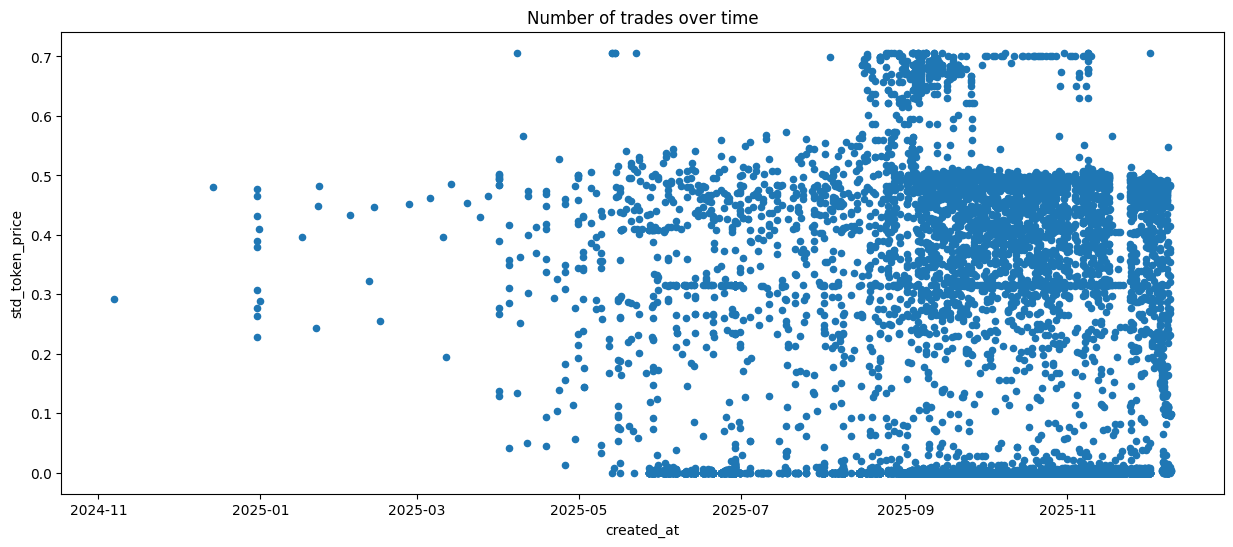

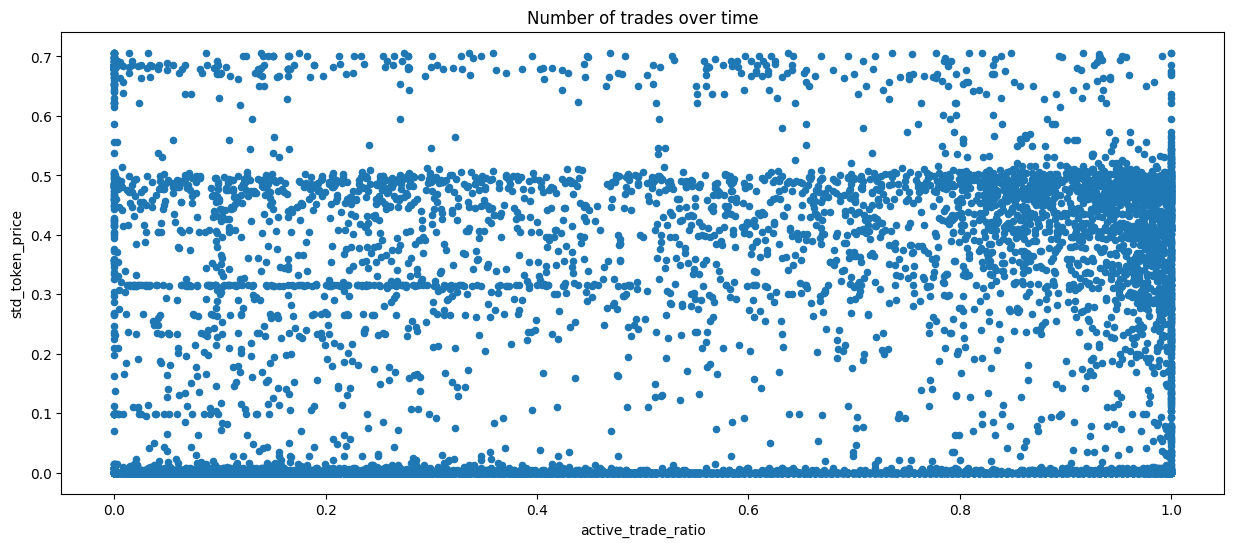

In [93]:
joined_crypto_summary_std_token_price.filter(
    pl.col('first_trade').is_not_null()
    ).to_pandas().plot(
        x='created_at', y='std_token_price', kind='scatter', title='Number of trades over time', figsize=(15, 6))

joined_crypto_summary_std_token_price.filter(
    pl.col('first_trade').is_not_null()
    ).to_pandas().plot(x='active_trade_ratio', y='std_token_price', kind='scatter', 
                       title='Number of trades over time', figsize=(15, 6))


In [94]:
print(joined_crypto_summary_std_token_price.select(['created_at']).min(),
      joined_crypto_summary_std_token_price.select(['created_at']).max())

shape: (1, 1)
┌─────────────────────┐
│ created_at          │
│ ---                 │
│ datetime[μs]        │
╞═════════════════════╡
│ 2020-10-02 20:00:04 │
└─────────────────────┘ shape: (1, 1)
┌─────────────────────┐
│ created_at          │
│ ---                 │
│ datetime[μs]        │
╞═════════════════════╡
│ 2025-12-10 05:32:19 │
└─────────────────────┘


<Axes: title={'center': 'Number of trades over time'}, xlabel='active_trade_ratio', ylabel='trade_count_norm'>

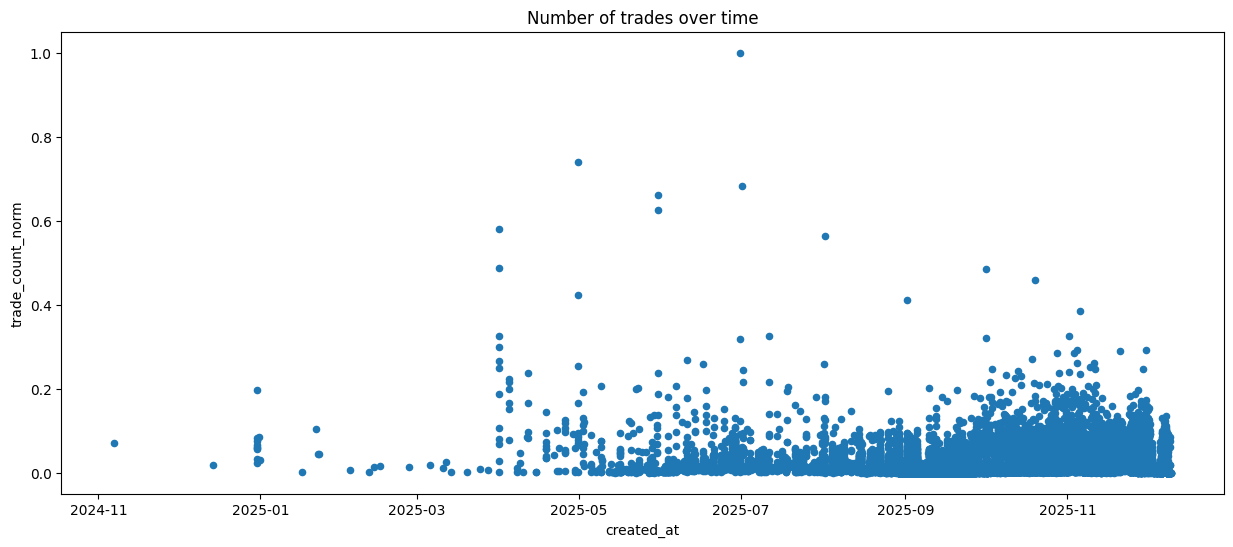

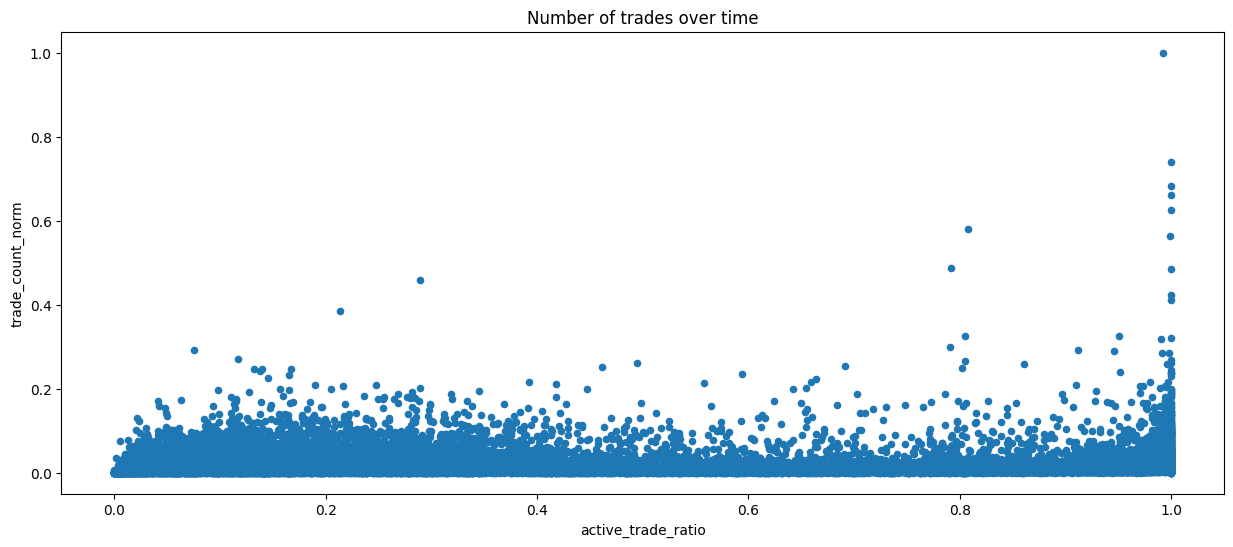

In [95]:
joined_crypto_summary_std_token_price.filter(
    pl.col('first_trade').is_not_null()
    ).to_pandas().plot(
        x='created_at', y='trade_count_norm', kind='scatter', title='Number of trades over time', figsize=(15, 6))

joined_crypto_summary_std_token_price.filter(
    pl.col('first_trade').is_not_null()
    ).to_pandas().plot(x='active_trade_ratio', y='trade_count_norm', kind='scatter', title='Number of trades over time', figsize=(15, 6))


In [ ]:
joined_crypto_summary_std_token_price.filter(pl.col('created_at')<pl.datetime(2020,10,31,0,0,0))

market_id,question,slug,volume,trade_count,created_at,end_date,market_open_duration_minutes,first_trade,last_trade,actual_market_trade_duration_minutes,active_trade_ratio,std_token_price,trade_count_norm
str,str,str,f64,i64,datetime[μs],datetime[μs],i64,datetime[ms],datetime[ms],i64,f64,f64,f64
"""63""","""Will BTC break $15k before 202…","""will-btc-break-15k-before-2021…",224706.49,0,2020-10-22 16:50:03,2021-01-01 00:00:00,101229,null,null,null,null,0.0,0.0
"""44""","""What will the USD price of Fil…","""what-will-the-usd-price-of-fil…",69947.1,0,2020-10-12 22:00:05,2020-11-17 00:00:00,50519,null,null,null,null,0.0,0.0
"""43""","""What will the total value lock…","""what-will-the-total-value-lock…",46944.58,0,2020-10-12 22:00:05,2021-01-02 00:00:00,116759,null,null,null,null,0.0,0.0
"""36""","""What will the price of Bitcoin…","""what-will-the-price-of-bitcoin…",59755.8,0,2020-10-02 20:00:04,2020-11-04 00:00:00,46319,null,null,null,null,0.0,0.0
"""57""","""Will Dharma’s Phase 1 Retroact…","""will-dharma-s-phase-1-retroact…",35661.94,0,2020-10-21 21:00:05,2020-10-31 00:00:00,13139,null,null,null,null,0.0,0.0


In [96]:
# joined_crypto_summary_stdprice
joined_crypto_summary_std_token_price_filtered = joined_crypto_summary_std_token_price.filter(pl.col('first_trade').is_not_null())

Maket strength index 



In [97]:
joined_crypto_summary_std_token_price_filtered.columns

['market_id',
 'question',
 'slug',
 'volume',
 'trade_count',
 'created_at',
 'end_date',
 'market_open_duration_minutes',
 'first_trade',
 'last_trade',
 'actual_market_trade_duration_minutes',
 'active_trade_ratio',
 'std_token_price',
 'trade_count_norm']

In [99]:
import polars as pl

def add_crypto_poly_index(
    df: pl.DataFrame,
    weights: dict | None = None,
) -> pl.DataFrame:
    if weights is None:
        weights = {
            "trade_count": 0.3,
            "volume": 0.3,
            "std_token_price": 0.2,
            "active_trade_ratio": 0.2,
        }

    def minmax(col: str) -> pl.Expr:
        c = pl.col(col)
        c_min = c.min()
        c_max = c.max()
        return (
            pl.when(c_max == c_min)
            .then(pl.lit(0.0))
            .otherwise((c - c_min) / (c_max - c_min))
        )

    df = df.with_columns(
        [
            pl.col("trade_count").log1p().alias("trade_count_log"),
            pl.col("volume").log1p().alias("volume_log"),
            pl.col("std_token_price").log1p().alias("std_token_price_log"),
        ]
    ).with_columns(
        [
            minmax("trade_count_log").alias("trade_count_norm"),
            minmax("volume_log").alias("volume_norm"),
            minmax("std_token_price_log").alias("std_token_price_norm"),
            minmax("active_trade_ratio").alias("active_trade_ratio_norm"),
        ]
    ).with_columns(
        (
            pl.col("trade_count_norm") * weights["trade_count"]
            + pl.col("volume_norm") * weights["volume"]
            + pl.col("std_token_price_norm") * weights["std_token_price"]
            + pl.col("active_trade_ratio_norm") * weights["active_trade_ratio"]
        )
        .clip(0.0, 1.0)
        .alias("crypto_poly_index")
    )

    return df

joined_crypto_summary_stdprice_index = add_crypto_poly_index(
    joined_crypto_summary_std_token_price_filtered,
    weights={"trade_count": 0.35, "volume": 0.35, "std_token_price": 0.0, "active_trade_ratio": 0.30},
)
joined_crypto_summary_stdprice_index.write_parquet(PROJECT_ROOT / "data" / "joined_crypto_summary_std_token_price_index.parquet")
joined_crypto_summary_stdprice_index


market_id,question,slug,volume,trade_count,created_at,end_date,market_open_duration_minutes,first_trade,last_trade,actual_market_trade_duration_minutes,active_trade_ratio,std_token_price,trade_count_norm,trade_count_log,volume_log,std_token_price_log,volume_norm,std_token_price_norm,active_trade_ratio_norm,crypto_poly_index
str,str,str,f64,i64,datetime[μs],datetime[μs],i64,datetime[ms],datetime[ms],i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""798778""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",8756.369075,279,2025-12-02 17:00:02,2025-12-09 17:00:00,10079,2025-12-09 04:35:47,2025-12-09 12:51:41,495,0.049112,0.294084,0.49525,5.63479,9.077651,0.257803,0.535081,0.482429,0.049112,0.375349
"""687200""","""Will Bitcoin reach $100,000 by…","""will-bitcoin-reach-100000-by-d…",3.0088e6,6795,2025-11-17 16:10:33,2026-01-01 05:00:00,64129,2025-11-26 11:11:15,2026-01-01 05:26:25,51495,0.802991,0.296799,0.81488,8.824089,14.917048,0.259899,0.879283,0.486352,0.802991,0.833854
"""865705""","""Will the price of XRP be betwe…","""will-the-price-of-xrp-be-betwe…",0.0,4,2025-12-06 17:00:07,2025-12-13 17:00:00,10079,2025-12-08 12:30:31,2025-12-08 15:22:51,172,0.017065,0.472366,0.09183,1.609438,0.0,0.38687,0.0,0.723954,0.017065,0.03726
"""894893""","""Bitcoin Up or Down - December …","""btc-updown-15m-1765282500""",3.920783,1178,2025-12-08 12:17:21,2025-12-09 12:30:00,1452,2025-12-08 12:37:29,2025-12-09 12:30:23,1432,0.986226,0.00101,0.639329,7.072422,1.593468,0.00101,0.093927,0.001889,0.986226,0.552507
"""834874""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",21.978011,1,2025-12-05 17:00:02,2025-12-12 17:00:00,10079,2025-12-07 17:12:25,2025-12-07 17:12:25,0,0.0,0.419105,0.0,0.693147,3.134538,0.350026,0.184765,0.655007,0.0,0.064668
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""594352""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",3612.0,2,2025-09-11 22:00:01,2025-09-12 04:00:00,359,2025-09-12 03:51:13,2025-09-12 03:51:13,0,0.0,0.0,0.040636,1.098612,8.192294,0.0,0.482894,0.0,0.0,0.183235
"""557086""","""Bitcoin Up or Down - July 17, …","""bitcoin-up-or-down-july-17-2pm…",36028.12231,743,2025-06-28 20:42:25,2025-07-17 19:00:00,27257,2025-07-16 20:04:32,2025-07-17 19:50:40,1426,0.052317,0.0,0.593189,6.612041,10.492083,0.0,0.618454,0.0,0.052317,0.43977
"""572176""","""Will Trump say ""Crypto"" or ""Bi…","""will-trump-say-crypto-or-bitco…",42908.041491,170,2025-08-04 23:57:55,2025-08-05 00:00:00,2,2025-08-05 01:29:05,2025-08-05 14:36:21,787,1.0,0.0,0.445829,5.141664,10.666838,0.0,0.628755,0.0,1.0,0.676104


<Axes: title={'center': 'Crypto Poly Index over Time'}, xlabel='created_at', ylabel='crypto_poly_index'>

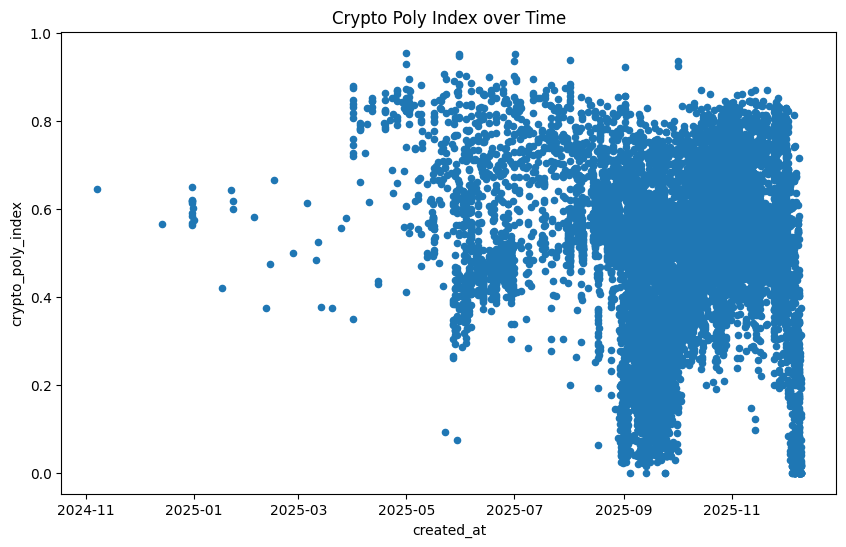

In [100]:
joined_crypto_summary_stdprice_index.to_pandas().\
    plot(x='created_at', y='crypto_poly_index', kind='scatter', title='Crypto Poly Index over Time', figsize=(10, 6))

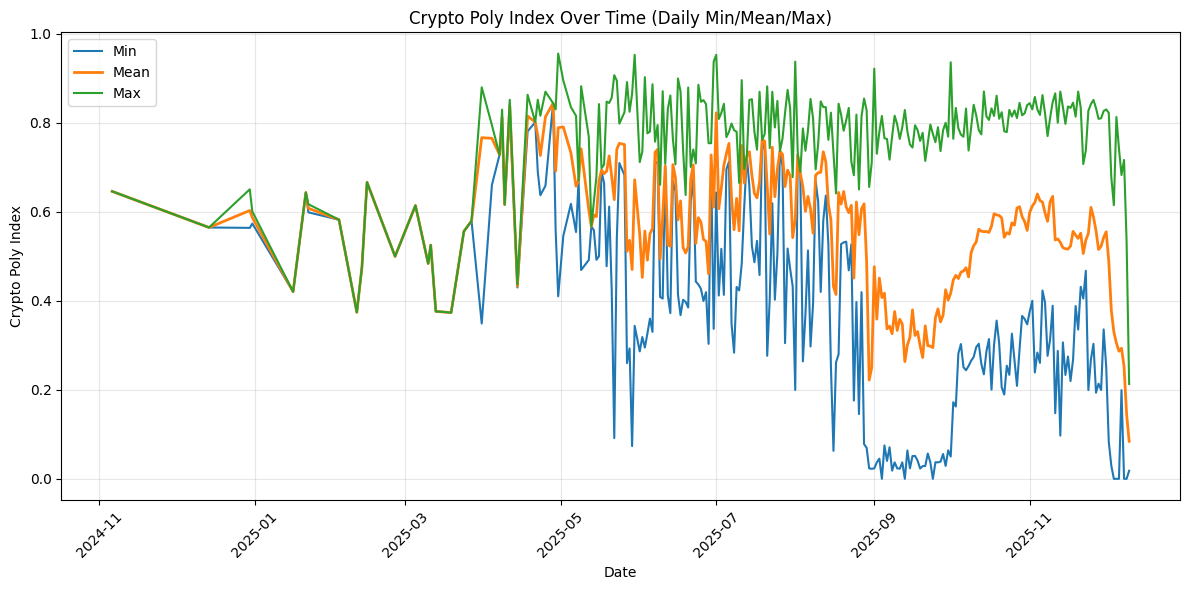

In [101]:
import matplotlib.pyplot as plt

df_poly_idx = joined_crypto_summary_stdprice_index.to_pandas()

daily = (
    df_poly_idx.dropna(subset=["created_at", "crypto_poly_index"])
          .assign(date=df_poly_idx["created_at"].dt.date)
          .groupby("date")["crypto_poly_index"]
          .agg(["min", "mean", "max"])
          .reset_index()
)

plt.figure(figsize=(12, 6))
plt.plot(daily["date"], daily["min"], label="Min", linewidth=1.5)
plt.plot(daily["date"], daily["mean"], label="Mean", linewidth=2)
plt.plot(daily["date"], daily["max"], label="Max", linewidth=1.5)
plt.title("Crypto Poly Index Over Time (Daily Min/Mean/Max)")
plt.xlabel("Date")
plt.ylabel("Crypto Poly Index")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# 
joined_crypto_summary_stdprice_index.write_parquet(PROJECT_ROOT / "data" / "joined_crypto_summary_std_token_price_index.parquet")

finance_politics_event_stats.parquet  

In [55]:
# markets_df = pl.scan_parquet(markets_path).collect()
fin_politics_event_stats_path = os.path.join(POLYMARKET_DIR, "finance_politics_event_stats.parquet" )
fin_pol_events = pl.scan_parquet(fin_politics_event_stats_path).collect()
fin_pol_events

event_slug,market_count,total_volume,first_market_start,last_market_end
str,i64,f64,datetime[μs],datetime[μs]
"""will-binancecom-become-insolve…",1,269.41,2023-01-24 21:09:31,2023-02-28 00:00:00
"""gme-market-cap-on-may-17""",7,112281.62,2024-05-13 17:51:35,2024-05-17 12:00:00
"""republican-vp-nominee""",25,9.2566e7,2024-01-18 19:14:19,2024-09-08 12:00:00
"""will-kevin-mccarthy-resign-fro…",1,6410.89,2023-11-12 19:11:54,2023-11-30 00:00:00
"""safe-market-cap-fdv-one-week-a…",6,116716.82,2024-03-26 17:01:59,2024-12-31 12:00:00
…,…,…,…,…
"""eth-updown-4h-1765429200""",1,0.0,2025-12-10 05:01:33,2025-12-11 09:00:00
"""sol-updown-4h-1765429200""",1,0.0,2025-12-10 05:01:33,2025-12-11 09:00:00
"""btc-updown-15m-1765431000""",1,267.31,2025-12-10 05:32:19,2025-12-11 05:45:00


In [56]:
fin_pol_events['event_slug'][0]

'will-binancecom-become-insolvent-by-feb-28-2023'

In [57]:
df_event_stats

event_slug,market_count,total_volume,first_market_start,last_market_end
str,i64,f64,datetime[μs],datetime[μs]
"""will-binancecom-become-insolve…",1,269.41,2023-01-24 21:09:31,2023-02-28 00:00:00
"""gme-market-cap-on-may-17""",7,112281.62,2024-05-13 17:51:35,2024-05-17 12:00:00
"""republican-vp-nominee""",25,9.2566e7,2024-01-18 19:14:19,2024-09-08 12:00:00
"""will-kevin-mccarthy-resign-fro…",1,6410.89,2023-11-12 19:11:54,2023-11-30 00:00:00
"""safe-market-cap-fdv-one-week-a…",6,116716.82,2024-03-26 17:01:59,2024-12-31 12:00:00
…,…,…,…,…
"""eth-updown-4h-1765429200""",1,0.0,2025-12-10 05:01:33,2025-12-11 09:00:00
"""sol-updown-4h-1765429200""",1,0.0,2025-12-10 05:01:33,2025-12-11 09:00:00
"""btc-updown-15m-1765431000""",1,267.31,2025-12-10 05:32:19,2025-12-11 05:45:00


In [72]:
raise NotImplementedError("End of EDA")


NotImplementedError: End of EDA